# Nonwall Bounces

# Initial Setup

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark

In [2]:
# Display the status of the machine and other non-code related info
%watermark -m -g -b -h

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.11.0-19-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Hostname: apra-desktop-ubuntu

Git hash: 8bc6778e2acfd01b921d04aff1635cb65631c055

Git branch: t2



Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [3]:
# Load `autoreload` extension
%load_ext autoreload

In [4]:
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [5]:
# Set the matplotlib mode
%matplotlib inline

## Imports

In [6]:
# Standard library imports
import shutil
from pathlib import Path

# Third party
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from loguru import logger

# %aimport hmdcpd.visualization
# %aimport hmdcpd.analysis
# from hmdcpd import (
#     visualization,
#     analysis,
# )

%aimport bouncing_ball_task.bouncing_ball
%aimport bouncing_ball_task.human_bouncing_ball.dataset
%aimport bouncing_ball_task.human_bouncing_ball.catch
%aimport bouncing_ball_task.human_bouncing_ball.straight
%aimport bouncing_ball_task.human_bouncing_ball.bounce
%aimport bouncing_ball_task.human_bouncing_ball.nonwall
%aimport bouncing_ball_task.human_bouncing_ball.defaults
%aimport bouncing_ball_task.utils.pyutils
%aimport bouncing_ball_task.utils.taskutils
%aimport bouncing_ball_task.utils.htaskutils
%aimport bouncing_ball_task.utils.visualize
%aimport bouncing_ball_task.utils.gif
from bouncing_ball_task.utils import pyutils, visualize, gif
from bouncing_ball_task.human_bouncing_ball import dataset as hbb
from bouncing_ball_task.human_bouncing_ball import defaults
from bouncing_ball_task import index

# Display  versions of everything
%watermark -v -iv

Python implementation: CPython
Python version       : 3.13.1
IPython version      : 8.31.0

pandas            : 2.2.3
seaborn           : 0.13.2
numpy             : 2.2.2
cv2               : 4.10.0
bouncing_ball_task: 0.0.0
matplotlib        : 3.10.0



In [7]:
# Suppress sci notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [8]:
from IPython.display import Video, HTML
from base64 import b64encode

def display_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(
        HTML(
            f"""
            <video width="400" controls autoplay loop>
                <source src="{data_url}" type="video/mp4">
                Your browser does not support the video tag.
            </video>
            """
        )
    )

# Loading Task Instance

In [9]:
# Task Parameters
rerun = True
task_parameters = defaults.task_parameters.asdict()
human_dataset_parameters = defaults.human_dataset_parameters.asdict()

task_parameters["batch_size"] = batch_size = 8
human_dataset_parameters["num_blocks"] = num_blocks = 2
human_dataset_parameters["variable_length"] = variable_length = True
human_dataset_parameters["total_videos"] = total_videos = batch_size
human_dataset_parameters["total_dataset_length"] = total_dataset_length = None
human_dataset_parameters["trial_type_split"] = trial_type_split = (1, 1, 5, 1)

In [10]:
task, list_samples, list_targets, df_data, dict_metadata = hbb.generate_video_dataset(
    human_dataset_parameters,
    task_parameters,
    shuffle=False,
)

rerun = True
mask_start = task.mask_start
mask_end = task.mask_end
mask_color = task.mask_color
samples = task.samples
targets = task.targets

2025-03-20 15:13:33.846 | DEBUG    | bouncing_ball_task.bouncing_ball:color_mask_mode:503 - Running color_mask_mode setter
2025-03-20 15:13:33.847 | DEBUG    | bouncing_ball_task.bouncing_ball:transitioning_change_mode:481 - Running transitioning_change_mode setter
2025-03-20 15:13:33.847 | DEBUG    | bouncing_ball_task.bouncing_ball:sequence_mode:433 - Running sequence_mode setter
2025-03-20 15:13:33.847 | DEBUG    | bouncing_ball_task.bouncing_ball:resample_change_probabilities:529 - Running resample_change_probabilities
2025-03-20 15:13:33.848 | DEBUG    | bouncing_ball_task.bouncing_ball:color_sampling:410 - Running color_sampling setter
2025-03-20 15:13:33.850 | DEBUG    | bouncing_ball_task.bouncing_ball:return_change_mode:467 - Running return_change_mode setter


Dataset Generation Summary
  Num Total Trials: 8 (1 min 13.3 sec)
    ball_radius:                         10
    dt:                                  0.1
    duration:                            30
    exp_scale:                           1.75
    border_tolerance_outer:              1.25
    mask_center:                         0.5
    mask_fraction:                       0.3333333333333333
    size_x:                              256
    size_y:                              256
    num_pos_x_endpoints:                 3
    num_pos_y_endpoints:                 4
    y_pos_multiplier:                    4
    pvc:                                 0.001
    num_y_velocities:                    2
    bounce_offset:                       0.4
    border_tolerance_inner:              1.0
    num_pos_x_linspace_bounce:           5
    idx_linspace_bounce:                 1
    bounce_timestep:                     7
    repeat_factor:                       3
    seed:                        

## Getting Video Paths

In [11]:
dir_base = index.dir_data
dir_name = "tmp"
dir_dataset = dir_base / dir_name
dir_videos = dir_dataset / "videos"

path_videos_inferred = [
    dir_videos / f"block_{block}/video_{video}/video_{video}_{color}.mp4"
    for (color, block, video) in
    df_data[["Final Color", "Dataset Block", "Dataset Block Video"]].to_numpy().tolist()
]

In [12]:
if (rerun or (
    dir_dataset.exists() and
    not np.all([path.exists() for path in path_videos_inferred])
)
   ):
    shutil.rmtree(dir_dataset)
    rerun = False

In [13]:
if not dir_dataset.exists():
    path_videos = hbb.save_video_dataset(
        dir_base,
        dir_name,
        df_data,
        dict_metadata,
        list_samples,
        list_targets,
        task,
        duration=defaults.duration,
        mode="original",
        multiplier=2,
        save_target=True,
        save_animation=True,
        display_animation=False,
        num_sequences=1,
        as_mp4=True,
        include_timestep=False,
        return_path=True,
    )

assert np.all(path.exists() for path in path_videos)
assert np.all(path.exists() for path in path_videos_inferred)
assert np.all((path in path_videos) for path in path_videos_inferred)

2025-03-20 15:13:33.929 | INFO     | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:496 - Saving dataset to /home/apra/Work/Bouncing-Ball-Task/data/tmp (dir_dataset)
2025-03-20 15:13:33.930 | INFO     | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:504 - Saving trial metadata to to /dir_dataset/trial_meta
2025-03-20 15:13:33.934 | INFO     | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:513 - Saving dataset metadata to to /dir_dataset/dataset_meta
2025-03-20 15:13:33.937 | DEBUG    | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:548 - Generating video files in /dir_dataset/videos/block_2/video_2
OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
2025-03-20 15:13:34.809 | DEBUG    | bouncing_ball_task.human_bouncing_ball.dataset:save_video_dataset:548 - Generating video files in /dir_dataset/vide

In [14]:
df_data["Path Videos"] = path_videos_inferred
df_data.head()

,idx_trial,trial,idx_time,side_left_right,side_top_bottom,idx_velocity_y,idx_x_position,idx_y_position,length,Final Color,...,Bounces,Random Bounces,Color Change Bounce,Color Change Random,PCCNVC_effective,PCCOVC_effective,PVC_effective,Hazard Rate,Contingency,Path Videos
Video ID,,,,,,,,,,,,,,,,,,,,,
0,0,Catch,-1,-1,-1,-1,-1,-1.00000,200,red,...,4,0,0,4,0.02041,0.00000,0.00000,High,Low,/home/apra/Work/Bouncing-Ball-Task/data/tmp/vi...
1,0,Straight,0,1,0,0,-1,-1.00000,206,red,...,4,0,0,0,0.00000,0.00000,0.00000,Low,Low,/home/apra/Work/Bouncing-Ball-Task/data/tmp/vi...
2,0,Bounce,-1,0,0,1,0,NaN,308,red,...,9,0,0,0,0.00000,0.00000,0.00000,Low,Low,/home/apra/Work/Bouncing-Ball-Task/data/tmp/vi...
3,1,Bounce,-1,1,1,0,1,NaN,228,green,...,5,0,1,5,0.02242,0.20000,0.00000,High,Medium,/home/apra/Work/Bouncing-Ball-Task/data/tmp/vi...
4,2,Bounce,-1,1,1,0,1,NaN,460,blue,...,9,0,8,10,0.02217,0.88889,0.00000,High,High,/home/apra/Work/Bouncing-Ball-Task/data/tmp/vi...


# Viewing Nonwall Bounce Trials

In [15]:
def display_video_idx(df_data, idx):
    video_data = df_data.iloc[idx]
    print(video_data)
    display_video(video_data["Path Videos"])

display_video_idx(df_data, -2)

idx_trial                                                              4
trial                                                             Bounce
idx_time                                                              -1
side_left_right                                                        0
side_top_bottom                                                        1
idx_velocity_y                                                         1
idx_x_position                                                         0
idx_y_position                                                       NaN
length                                                               216
Final Color                                                          red
Final X Position                                               125.11467
Final Y Position                                               222.60667
Final X Velocity                                                27.30667
Final Y Velocity                                   

In [16]:
def plot_effective_stats(df_data):
    # Create the subplots
    palette = visualize.get_color_palette(
        ["Low", "High"],
        (("Blues", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )
    palette_trial = visualize.get_color_palette(
        ["Straight", "Catch", "Bounce"],
        (("Blues", 1), ("Wistia", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )
    palette_contingency = visualize.get_color_palette(
        ["Low", "Medium", "High"],
        (("Blues", 1), ("Wistia", 1), ("Reds", 1)),
        linspace_range=(0.75, 1),
    )
    
    plot_params = [
        [
            (
                "PCCNVC_effective",
                "Observed Hazard Rates",
                "Effective Hazard Rate Bins",
                {
                    "hue": "Hazard Rate",
                    "legend": False,
                    "palette": palette,
                }
            ),
            (
                "Color Change Random",
                "Number of Random Color Changes",
                "Random Color Change Bins",
                {
                    "hue": "Hazard Rate",
                    "legend": True,
                    "discrete": True,
                    "palette": palette,
                }
            ),
            (
                "length",
                "Distribution of Video Lengths",
                "Video Length Bins",
                {
                    "hue": "trial",
                    "legend": True,
                    "palette": palette_trial,
                }
            ),
        ],
        [
            (
                "PCCOVC_effective",
                "Observed Trial Contingency",
                "Effective Contingency Bins",
                {
                    "hue": "Contingency",
                    "palette": palette_contingency,
                    "legend": False,
                },
            ),
            (
                "Color Change Bounce",
                "Number of Bounce Color Changes",
                "Bounce Color Changes",
                {
                    "discrete": True,
                    "hue": "Contingency",
                    "palette": palette_contingency,
                    "legend": True,
                }
            ),
            (
                "Bounces",
                "Number of Bounces",
                "Number of Bounces",
                {
                    "discrete": True,
                    "hue": "trial",
                    "palette": palette_trial,
                    "legend": True,
                }
            ),
        ],
    ]
    
    rows = 2
    fig, axes = plt.subplots(
        rows,
        len(plot_params[0]),
        figsize=(len(plot_params[0])*4, rows*4),
    )
    
    for i, row_plots in enumerate(plot_params):
        for j, (col, title, xlabel, plot_dict) in enumerate(row_plots):
            ax = axes[i, j]
            sns.histplot(
                df_data,
                x=col,
                ax=ax,
                **plot_dict,
            )
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            if j != 0:
                ax.set_ylabel(None)
    
    plt.suptitle(f"Task Statstics for {batch_size} Videos")
    plt.tight_layout()
    plt.show()

ValueError: The palette dictionary is missing keys: {'Nonwall'}

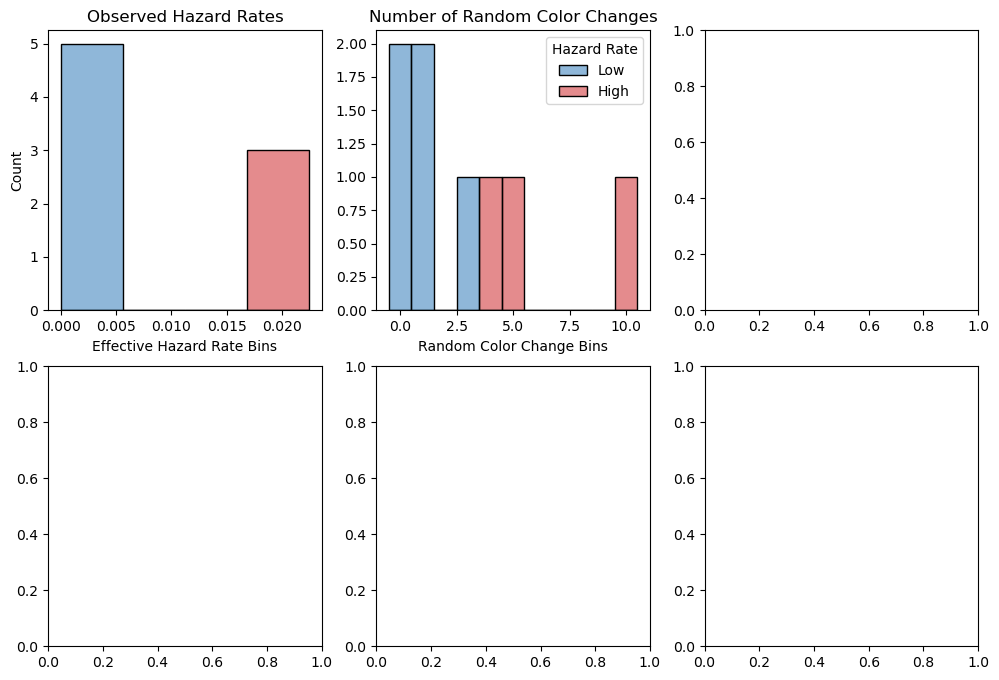

In [17]:
plot_effective_stats(df_data)